# **Transverse Field Ising Model**

Ising Model is a theoretical model to describe ferromagnetism in solids. It simplifies the complex properties of solids by assuming only nearest neighbor interaction between lattice sites and allowing only two opposite pointing orientations of each lattice site’s magnetic moment. Physically it's the opposite of an Ideal gas, as the particles are fixed but can interact compared to non-interacting moving particles in the Ideal gas. For details, see [Ising model](https://www.thphys.uni-heidelberg.de/~wolschin/statsem20_3s.pdf).

From a Computer Science perspective, NP-hard problems, including all of Karp's 21 NP-complete problems can be mapped to the Ising model with a polynomial overhead. Thus, any NP-hard problem can be reduced to finding the ground state of the Ising model. For further reference, look at [Ising formulations of NP-Complete problems](https://www.frontiersin.org/journals/physics/articles/10.3389/fphy.2014.00005/full).

Over time, Ising models have been applied to various other fields such as *Machine Learning (Hopfield networks)*, *Biology (Protein folding)*, and *Physics (Quantum phase transitions)*. The **Transverse Field Ising Model (TFIM)** is a quantum version of the Ising model, where spins are replaced by qubits and the interaction between spins is modified by a transverse magnetic field. This model is used to study quantum phase transitions and has applications in Quantum Computing and Condensed Matter Physics.


The Hamiltonian of the Transverse Field Ising Model is given by:

$$H = -J\sum_{i=1}^{N} X_i X_{i+1} - h\sum_{i=1}^N Z_i$$

- *$X$:* The Pauli $\sigma_x$ matrix (for spin measurement)
- *$Z$:* The Pauli $\sigma_z$ matrix (for transverse field) 
- *Ferromagnetic coupling ($J$)*: Favors alignment of neighboring spins along X.  
- *Transverse field ($h$)*: Induces quantum fluctuations, polarizing spins along J.
- The boundary condition is periodic, meaning the last spin interacts with the first spin.

**Note:** In most references, the Hamiltonian will have Pauli matrices in the opposite order, i.e., $H = -J\sum_{i=1}^{N-1} Z_{i+1} Z_i - h\sum_{i=1}^N X_i$. This is due to the convention of defining the spin along Z axis in Condensed Matter Physics. The reason we switch Pauli X and Z is due to the Z2 ansatz we will be using for the VQE. Everything else remains the same, if you are doing any calculation wrt to the standard TFIM Hamiltonian, just switch the Pauli matrices.

### **Ground States and Symmetry**

#### h >> J (Paramagnetic Phase): 
When h is much larger than J, the spins tend to align along the Z-axis, leading to magnetization in the Z direction (ferromagnetic phase). Thus, the two degenerate ground states are:
$$
|\psi^{0+}\rangle = \otimes_{n=1}^N | \uparrow \rangle_n, \quad |\psi^{0-}\rangle = \otimes_{n=1}^N | \downarrow \rangle_n
$$  
These exhibit non-zero magnetization $M =\pm N$, where $N$ is the number of spins. The $\mathbf{Z}_2$ symmetry is broken, and the system has two degenerate ground states.

#### J >> h (Ferromagnetic Phase): 
When J is much larger than h, the spins are polarized along the X-axis, leading to disordered state. 
Here Magnetization M = 0 and $\mathbf{Z}_2$ symmetry is preserved. The unique symmetric ground state is:
$$
|\psi^{0\to}\rangle = \bigotimes_{n=1}^N \frac{1}{\sqrt{2}} \left( | \uparrow \rangle_n + | \downarrow \rangle_n \right) = \otimes_{n=1}^N | \rightarrow \rangle_n
$$

The $\mathbb{Z}_2$ symmetry corresponds to a *global spin-flip* operation:
$ G = \otimes_i \sigma_i^z, $
which satisfies $G^2 = 1$, forming the cyclic group $\mathbb{Z}_2$.

Interaction term $\sigma_i^x \sigma_j^x$:
  $\quad G (\sigma_i^x \sigma_j^x) G^{-1} = \sigma_i^x \sigma_j^x \quad (\text{invariant}).$

Transverse field term $\sigma_i^x$:
  $\quad G (\sigma_i^z) G^{-1} = \sigma_i^z \quad (\text{invariant}).$

The Hamiltonian $H$ is invariant under $G$, confirming $\mathbb{Z}_2$ symmetry.

*The goal of this tutorial will be implementing Transverse Field Ising Models using QURI-Parts. We will approximate the ground state energy, wavefunction of the TFIM Hamiltonian using VQE and further improving it using QSCI. Finally we will calculate the correlation length and show divergence at the critical point which are relevant to Condensed Matter Physicist.*

### Setting up the QubitHamiltonian in QURI

In [212]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence
from quri_parts.core.operator import Operator, pauli_label, get_sparse_matrix

def construct_TFIM_hamiltonian(J, h, n_qubits):
    hamiltonian = Operator()

    # Add Ising interaction terms (-J Σ X_i X_{i+1}) (Assuming periodic boundary conditions)
    for i in range(n_qubits):
        pauli_index = pauli_label('X'+str(i)+' X'+str((i+1)%n_qubits))
        hamiltonian.add_term(pauli_index, -J)

    # Add transverse field terms (-h Σ Z_i)
    for i in range(n_qubits):
        pauli_index = pauli_label('Z'+str(i))
        hamiltonian.add_term(pauli_index, -h)

    return hamiltonian


In [213]:
# Parameters
n_qubits = 11        # Number of spins/qubits
J = 1.0             # Interaction strength
h = 1.0             # Transverse field strength

hamiltonian = construct_TFIM_hamiltonian(J, h, n_qubits)

Since *n_qubits* is small, we can find the smallest eigenvalue (ground energy state) of the Hamiltonian matrix directly. This is only performed for benchmarking. For relistic physical systems involving large *n_qubits*, this computation is not feasible and we have to rely on Quantum Computing methods to find the approximate ground state.

In [214]:
## Ground eigenvalue and eigenvector computation using numpy (Will be later used for benchmarking)
vals, vecs = np.linalg.eigh(get_sparse_matrix(hamiltonian).toarray())

EXACT_GS_ENERGY = np.min(vals)
EXACT_GAP = vals[np.argsort(vals)][:2] @ [-1, 1]

print("E_0:", EXACT_GS_ENERGY)
print("Delta (E_1 - E_0)):", EXACT_GAP)

E_0: -14.053348366664528
Delta (E_1 - E_0)): 0.14304282311756822


### Statistical Phase Estimation (SPE):

Statistical Phase Estimation (SPE) is a ground state energy estimation (GSEE) algorithm meant to run on Early Fault Tolerant Quantum Computing (EFTQC) architectures. Essentially SPE estimates the ground state using a shorter depth circuit than Quantum Phase Estimation (QPE) which requires longer circuit depth and fully fault tolerant architecture. Also SPE has shorter fewer shot complexity than VQE. For further details, you can refer to this [notebook](https://github.com/QunaSys/quri-sdk-notebooks/blob/main/quri_sdk_notebooks/examples/0_quri-algo-vm/1_spe/1_spe.ipynb) or the [original paper](https://arxiv.org/abs/2409.07749)

 In SPE to estimate the ground state of a Hamiltonian, we need to encode our Hamiltonian into a controlled time evolution circuit ($e^{-i H t}$). Here we will do this time evolution with Trotterization. In QURI Parts, we wrap the hamiltonian into QubitHamiltonianInput for encoding into a circuit later.

In [61]:
from quri_algo.problem import QubitHamiltonianInput

qubit_hamiltonian = QubitHamiltonianInput(n_qubits, hamiltonian)

The SPE algorithm requires an esimtation of $<e^{-iHt}>$ on different evolution time $t$. We build the exact estimator and another one that based on Hadamard test with Trotterized time evolution operator.

In [63]:
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from quri_algo.circuit.time_evolution.trotter_time_evo import TrotterControlledTimeEvolutionCircuitFactory
from quri_algo.core.estimator.time_evolution_estimator.trotter import TrotterTimeEvolutionHadamardTest


# Setting the num_trotter steps to 30
trotter_concotrolled_time_evo_circuit_factory = (
    TrotterControlledTimeEvolutionCircuitFactory(qubit_hamiltonian, n_trotter=30)
)

# Time-evolution with t=1
c_time_evo = trotter_concotrolled_time_evo_circuit_factory(evolution_time=1)

sampler = create_qulacs_vector_sampler()
trotter_time_evolution_estimator = TrotterTimeEvolutionHadamardTest(qubit_hamiltonian, sampler, 50)

We pick a trial state $|\psi\rangle$ and compute the overlap with the ground state $|\psi^0\rangle$ of the Hamiltonian $H$.

In [8]:
from quri_parts.core.state import quantum_state
from quri_parts.qulacs.simulator import evaluate_state_to_vector


trial_state = quantum_state(n_qubits, bits=0) 
gs_overlap = np.abs(evaluate_state_to_vector(trial_state).vector @ vecs[:, 0])**2
print(f"Overlap between the chosen state and the exact grounds state vector: {gs_overlap: .1e}")

Overlap between the chosen state and the exact grounds state vector:  6.8e-01


In [10]:
from quri_algo.algo.phase_estimation.spe import StepFunctionParam
from quri_algo.algo.phase_estimation.spe.lt22 import SingleSignalLT22GSEE

# Initializing the parameters for 
d_max = 1000
delta = 1e-4
n_sample = 10000
tau = 1 / 20
eta = 0.4

signal_param = StepFunctionParam(d=d_max, delta=delta, n_sample=n_sample)
lt22_algorithm = SingleSignalLT22GSEE(trotter_time_evolution_estimator, tau=tau)
spe_result = lt22_algorithm(trial_state, signal_param, eta)

lt22_gs_energy = spe_result.phase / tau
print(f"The obtained ground state energy is {lt22_gs_energy}")
print(f"The error is = {abs(lt22_gs_energy - np.min(vals))}")

The obtained ground state energy is -7.260219928402891
The error is = 0.03600988215586565


## **VQE Optimization**

As discussed previously, TFIM Hamiltonian is invariant under $\mathbf{Z}_2$ symmetry. The ansatz we choose for  the VQE optimzation also respects this symmetry. For further details on the ansatz, refer to this [paper]()

In [215]:
from quri_parts.algo.ansatz import Z2SymmetryPreservingReal
from quri_parts.circuit.utils.circuit_drawer import draw_circuit

parametric_circuit = Z2SymmetryPreservingReal(n_qubits, 7)
draw_circuit(parametric_circuit)

                           ___     ___     ___                             ___  
                          |PR |   |PRZ|   |PR |                           |PR | 
--------------------------|20 |---|21 |---|23 |---------------------------|60 |-
                          |   |   |___|   |   |                           |   | 
   ___     ___     ___    |   |    ___    |   |    ___     ___     ___    |   | 
  |PR |   |PRZ|   |PR |   |   |   |PRZ|   |   |   |PR |   |PRZ|   |PR |   |   | 
--|0  |---|1  |---|3  |---|   |---|22 |---|   |---|40 |---|41 |---|43 |---|   |-
  |   |   |___|   |   |   |___|   |___|   |___|   |   |   |___|   |   |   |___| 
  |   |    ___    |   |    ___     ___     ___    |   |    ___    |   |    ___  
  |   |   |PRZ|   |   |   |PR |   |PRZ|   |PR |   |   |   |PRZ|   |   |   |PR | 
--|   |---|2  |---|   |---|24 |---|25 |---|27 |---|   |---|42 |---|   |---|64 |-
  |___|   |___|   |___|   |   |   |___|   |   |   |___|   |___|   |___|   |   | 
   ___     ___     ___    | 

Setting up the parameteric state for the VQE Optimization.

In [216]:
from quri_parts.core.state import quantum_state, apply_circuit

cb_state = quantum_state(n_qubits, bits=0)
parametric_state = apply_circuit(parametric_circuit, cb_state)

We define closures (higher-order functions) that takes the Hamiltonian as the parameter and returns cost and gradient estimators for the VQE optimization. The cost estimator computes the expectation value of the Hamiltonian with respect to the parametric state, while the gradient estimator computes the gradient of the expectation value with respect to the parameters of the parametric state.

In [217]:
from quri_parts.core.estimator.gradient import create_parameter_shift_gradient_estimator
from quri_parts.qulacs.estimator import create_qulacs_vector_concurrent_parametric_estimator, create_qulacs_vector_parametric_estimator


estimator = create_qulacs_vector_parametric_estimator()

def H_cost_fn(hamiltonian):
    def cost_fn(param_values: Sequence[float]):
        estimate = estimator(hamiltonian, parametric_state, param_values)
        return estimate.value.real
    return cost_fn

In [218]:
concurrent_parametric_estimator = create_qulacs_vector_concurrent_parametric_estimator()
gradient_estimator = create_parameter_shift_gradient_estimator(concurrent_parametric_estimator)

def H_grad_fn(hamiltonian):
    def grad_fn(param_values: Sequence[float]) -> Sequence[float]:
        estimate = gradient_estimator(hamiltonian, parametric_state, param_values)
        return np.asarray([g.real for g in estimate.values])
    return grad_fn

Setting up the VQE optimization loop.

In [75]:
from quri_parts.algo.optimizer import Adam, OptimizerStatus

def vqe(
    init_params: Sequence[float],
    cost_fn,
    grad_fn,
    optimizer,
    hamiltonian
):

    cost_fn = H_cost_fn(hamiltonian)
    grad_fn = H_grad_fn(hamiltonian)

    opt_state = optimizer.get_init_state(init_params)
    while True:
        opt_state = optimizer.step(opt_state, cost_fn, grad_fn)
        if opt_state.status == OptimizerStatus.FAILED:
            print("Optimizer failed")
            break
        if opt_state.status == OptimizerStatus.CONVERGED:
            print("Optimizer converged")
            break
    return opt_state

In [219]:
adam_optimizer = Adam()
init_params = np.random.random(parametric_circuit.parameter_count)
vqe_state = vqe(init_params, H_cost_fn, H_grad_fn, adam_optimizer, hamiltonian)
bound_state = parametric_state.bind_parameters(vqe_state.params)

print("Optimized value:", vqe_state.cost)
print("Optimized parameter:", vqe_state.params)
print("Iterations:", vqe_state.niter)

Optimizer converged
Optimized value: -13.950391364532244
Optimized parameter: [ 0.70736558  0.48053615  0.84418981  0.40358891  0.09494895  0.88792201
  0.20334894  0.36172874  0.02854943  0.55688924  0.14325401  0.18579428
  0.88114586  1.22612937  0.22699486  0.24632779 -0.19722183  0.21022044
  0.34146882  0.55759545  0.72003076  0.65425888  1.50465412  0.9184075
  0.15485146  0.15090107 -0.15629045  0.24899512  1.260525    0.45420649
  0.22355148  0.42620163  1.42310764  1.13858022  0.04340455  0.2005506
  0.95210587  1.53508937  0.97666041  0.01043898  0.86620536  1.02020328
  1.5927295   1.12613882  0.33846658  1.05294299  0.72233456 -0.46697982
  0.76181798  0.47055485  0.51413945 -0.15584679  0.10125264  0.27913915
 -0.0789319   0.52708242 -0.29184704  0.45623595  0.05676062  0.49677566
  0.78859331  0.1921365  -0.33610705  0.20746666  1.02850929  0.48738245
  0.61561716  0.46759985  0.45323672  0.37021682  0.08773126  0.22105015
  0.17441044  0.571826    0.67715525  0.79142819

### **QSCI**

Quantum Selected Configuration Interaction (QSCI) is a hybrid quantum-classical algorithms for calculating the ground- and excited-state energies for a given Hamiltonian. It works on top of an approximate ground state estimated using VQE or by some other method. Then, by sampling the state in the computational basis, which is hard for classical computation in general, one can identify the basis states that are important for reproducing the ground state. The Hamiltonian in the subspace spanned by those important configurations is diagonalized on classical computers to output the ground-state energy and the corresponding eigenvector. The excited-state energies can be obtained similarly. The result is robust against statistical and physical errors. For further details, refer to this [notebook](https://github.com/QunaSys/quri-sdk-notebooks/blob/main/quri_sdk_notebooks/examples/0_quri-algo-vm/0_qsci/0_qsci.ipynb) or the [original paper](https://arxiv.org/abs/2302.11320).

In [223]:
BASIS_STATES = 1000
TOTAL_SHOTS = 1000000

In [224]:
from quri_parts.qulacs.sampler import create_qulacs_vector_concurrent_sampler
from quri_parts_qsci import qsci

sampler = create_qulacs_vector_concurrent_sampler()
eigs, ground_state = qsci(
    hamiltonian, [bound_state], sampler, total_shots=TOTAL_SHOTS, num_states_pick_out=BASIS_STATES
)

In [225]:
print("Ground state energy as per QSCI:", eigs[0])
print("Error (QSCI Ground energy - Actual Ground State energy):", np.abs(eigs[0] - np.min(vals)))

Ground state energy as per QSCI: -14.050027300028702
Error (QSCI Ground energy - Actual Ground State energy): 0.0033210666358254315


## **Quantum Phase Transition**:

Quantum phase transition is defined as the phenomenon where a major re-structuring of the ground state of a Quantum mechanical system occurs as a parameter of the Hamiltonian of the system is varied.

In Transverse Field Ising Model between the limits, $h << J$ and $h >> J$, the nature of the ground state changes. When $h >> J$ there are two ground states, with opposite signs of magnetization. When $J >> h$ there is a single ground state with zero magnetization. The transverse Ising model is interesting because it exhibits a second order “quantum phase transition” at a critical value of $\frac{h}{J}$. Here, a doublet of degenerate ground states, each with nonzero spontaneous magnetization must merge to form a unique ground state with zero magnetization. The quantum phase transition is of “second order” because the ground state energy, as a function of the parameter which is being varied to find the phase transition, has a discontinuous second derivative.

### **Magnetization**

The magnetization of the system is the sum of magnetic moment per spin. Here by magnetization we mean the Longitudinal Magnetization along the X-axis.

$$
M_x = \langle \sum_{n=1}^N \sigma_n^x \rangle
$$

In [241]:
from quri_parts.qulacs.estimator import create_qulacs_vector_estimator
qulacs_estimator = create_qulacs_vector_estimator()

magnetization_operator = Operator()
for i in range(n_qubits):
    pauli_index = pauli_label('Z'+str(i))
    magnetization_operator.add_term(pauli_index, 1)

def calculate_magnetization(quantum_state):
    return qulacs_estimator(magnetization_operator, quantum_state)
    

In [242]:
print("Magnetization for Ground State Obtained:", calculate_magnetization(ground_state[0][1][0]).value)

Magnetization for Ground State Obtained: (11+0j)


### Correlation Length and Divergence at Critical point

The *Correlation length* of a Quantum many body system quantifies how spins at different lattice sites are correlated for the ground state. For the *Transverse Field Ising Model (TFIM)*, it is defined as:

$$
C(r) = \langle \sigma_i^x \sigma_{i+r}^x \rangle - \langle \sigma_i^x \rangle \langle \sigma_{i+r}^x \rangle,
$$

where $r = |i - j|$ is the distance between spins. The *correlation length* $\xi$ is the characteristic length scale over which these correlations decay.

In [ ]:
def C_r(quantum_state, r):
    pair_corr_operator = Operator()
    for i in range(n_qubits):
        if i+r >= n_qubits:
            break
        pauli_index = pauli_label('X'+str(i)+' X'+str(i+r))
        pair_corr_operator.add_term(pauli_index, 1)  

    normal_corr_operator = Operator()
    for i in range(n_qubits):
        pauli_index = pauli_label('X'+str(i))
        normal_corr_operator.add_term(pauli_index, 1) 

    shifted_corr_operator = Operator()
    for i in range(n_qubits):
            if i+r >= n_qubits:
                break   
            pauli_index = pauli_label('X'+str(i+r))
            shifted_corr_operator.add_term(pauli_index, 1)

    return (
        qulacs_estimator(pair_corr_operator, quantum_state).value - 
        qulacs_estimator(normal_corr_operator, quantum_state).value * qulacs_estimator(shifted_corr_operator, quantum_state).value
    )/n_qubits

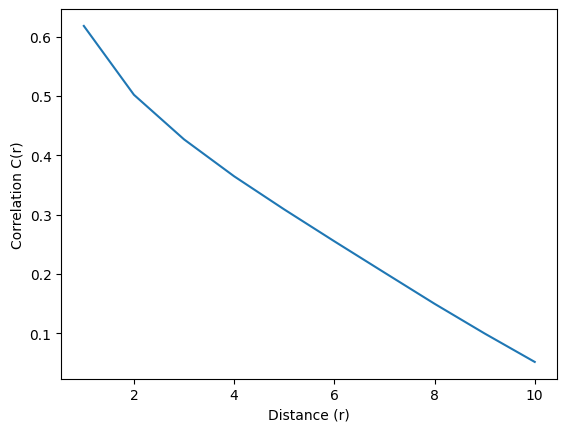

In [229]:
r = np.arange(1, n_qubits)
correlation = []

for i in r:
    correlation.append(C_r(bound_state, i))

plt.xlabel('Distance (r)')
plt.ylabel('Correlation C(r)')
plt.plot(r, np.real(correlation))

Fitting the correlation function to an exponential decay form:
$$
C(r) \sim e^{-r/\xi},
$$
the correlation length $\xi$ can be extracted from the decay rate. Near the critical point, the correlation length diverges, indicating long-range correlations in the system.

In [230]:
from scipy.optimize import curve_fit

def exp_decay(r, xi): 
    return np.exp(-r/xi)

popt, _ = curve_fit(exp_decay, r, np.real(correlation))
print("The correlation length ξ is:", popt[0])


The correlation length ξ is: 3.729359692085465


Now we will be calculating the correlation length for the Transverse Field Ising Model using the VQE optimized ground state wavefunction further improved using QSCI for different values of h i.e. different J/h ratios. The correlation length should diverge at the critical point, which is a characteristic feature of quantum phase transitions.

In [233]:
h = np.linspace(0.95, 1.05, 15)
correlation_len = []

for i in h:
    # Initializing the Hamiltonian Operator
    hamiltonian = construct_TFIM_hamiltonian(J, i, n_qubits)
    
    # VQE Optimization
    vqe_state = vqe(vqe_state.params, H_cost_fn, H_grad_fn, adam_optimizer, hamiltonian)
    state = parametric_state.bind_parameters(vqe_state.params)
    eigs, ground_state = qsci(
        hamiltonian, [state], sampler, total_shots=TOTAL_SHOTS, num_states_pick_out=BASIS_STATES
    )
    zero_eigvec = ground_state[0][1][0]

    # Computing the C(r) curve
    correlation = []
    for i in range(1, n_qubits):
        correlation.append(C_r(zero_eigvec, i))

    #Fitting to exponential decay curve
    popt, _ = curve_fit(exp_decay, r, np.real(correlation))
    correlation_len.append(popt[0])


Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged


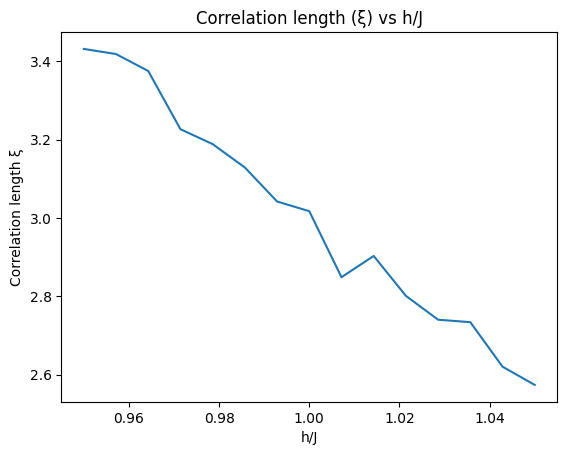

In [210]:
plt.title('Correlation length (ξ) vs h/J')
plt.xlabel('h/J')
plt.ylabel('Correlation length ξ')
plt.plot(h, correlation_len)

#### Magntic Susceptibility

The *magnetic susceptibility* $\chi$ is a measure of how the magnetization of a system responds to an external magnetic field. It is defined as:
$$
\chi = \frac{\partial M}{\partial h}
$$
where $M$ is the magnetization and $h$ is the transverse field. The magnetic susceptibility diverges at the critical point, indicating a phase transition.

In [235]:
magnetization = []
h = np.linspace(0.95, 1.05, 10)

for i in h:
    hamiltonian = construct_TFIM_hamiltonian(J, i, n_qubits)
    vqe_state = vqe(vqe_state.params, H_cost_fn, H_grad_fn, adam_optimizer, hamiltonian)
    state = parametric_state.bind_parameters(vqe_state.params)
    eigs, ground_state = qsci(
        hamiltonian, [state], sampler, total_shots=TOTAL_SHOTS, num_states_pick_out=BASIS_STATES
    )
    zero_eigvec = ground_state[0][1][0]

    magnetization.append(calculate_magnetization(zero_eigvec).value)

Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged
Optimizer converged


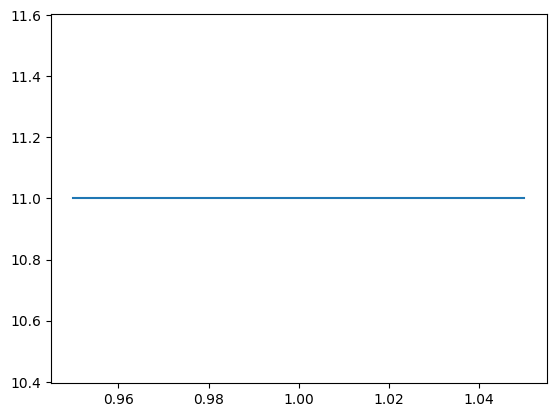

In [236]:
plt.plot(h, np.abs(magnetization))

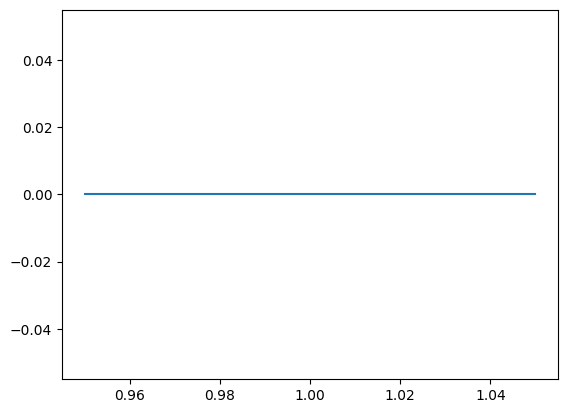

In [237]:

plt.plot(h, np.gradient(np.abs(magnetization), h[1] - h[0]))

### **Exact Solution via Jordan-Wigner Transformation**  

Jordan-Wigner transformation maps qubits to fermions and vice versa, allowing us to express the TFIM Hamiltonian in terms of fermionic operators. This transformation is crucial for diagonalizing the Hamiltonian and finding the exact ground state energy.

#### *Map spins to fermions:*  
$$
a_n = \sigma_n^- \prod_{m=1}^{n-1} (-\sigma_m^z), \quad 
a_n^\dagger = \sigma_n^+ \prod_{m=1}^{n-1} (-\sigma_m^z)
$$

where $\sigma_n^{\pm} = \frac{1}{2}(\sigma_n^x \pm i\sigma_n^y)$. The string operator $\prod_{m=1}^{n-1} (-\sigma_m^z)$ ensures fermionic anti-commutation relations:

$$
\{a_m, a_n^\dagger\} = \delta_{mn}, \quad \{a_m, a_n\} = 0.
$$

Inverse relations:
  $$
  \sigma_n^z = 1 - 2a_n^\dagger a_n, \quad
  \sigma_n^x = (a_n^\dagger + a_n) \prod_{m=1}^{n-1} (1 - 2a_m^\dagger a_m)
  $$


#### *Hamiltonian in Fermionic Terms*:  
Substituting into the TFIM Hamiltonian $H = -J\sum_{n=1}^{N} \sigma_n^z \sigma_{n+1}^z - h\sum_{n=1}^N \sigma_n^x$:

$$
H = J\sum_{n=1}^{N} (a_n^\dagger - a_n)(a_{n+1}^\dagger + a_{n+1}) + h\sum_{n=1}^N (1 - 2a_n^\dagger a_n)
$$

This represents:
- **Pairing terms**: $(a_n^\dagger a_{n+1}^\dagger - a_n a_{n+1} + \text{h.c.})$
- **Hopping terms**: $(a_n^\dagger a_{n+1} + a_{n+1}^\dagger a_n)$
- **On-site potential**: $h(1 - 2a_n^\dagger a_n)$

#### *Diagonalization via Fourier and Bogoliubov Transforms*
Diagonalized Hamiltonian:
$$
H = \sum_k \epsilon_k \left( \gamma_k^\dagger \gamma_k - \frac{1}{2} \right)
$$

where $\gamma_k = u_k a_k - iv_k a_{-k}^\dagger, \quad |u_k|^2 + |v_k|^2 = 1$. And $u_k = \cos\theta_k$, $v_k = \sin\theta_k$ with $\tan(2\theta_k) = \frac{J \sin k}{h - J \cos k}$.

#### *Energy Spectrum and Quantum Phase Transition*
Dispersion Relation
$$
\epsilon_k = 2\sqrt{h^2 + J^2 - 2hJ \cos k}
$$

Energy Gap
$$
\Delta = \min_k \epsilon_k = 2|J - h|
$$

| **Phase**          | **Condition** | **Gap** | **Order Parameter**       |
|--------------------|---------------|---------|---------------------------|
| Ferromagnetic (FM) | $h < J$       | $2(J-h)$| $\langle \sigma^z \rangle \neq 0$ |
| Paramagnetic (PM)  | $h > J$       | $2(h-J)$| $\langle \sigma^z \rangle = 0$    |
| **Critical Point** | $h = J$       | 0       | Conformal field theory    |

At criticality ($h = J$), the dispersion becomes linear: $\epsilon_k \approx 2J|k|$ for $k \approx 0$.


#### *Critical Exponents*
From exact solution:

| Exponent | Value | Definition                     |
|----------|-------|--------------------------------|
| $\nu$    | 1     | $\xi \approx |h-J|^{-\nu}$         |
| $\beta$  | 1/8   | $\langle \sigma^z \rangle \approx |J-h|^\beta$ |
| $\gamma$ | 7/4   | $\chi \approx |h-J|^{-\gamma}$       |

Matching the 2D classical Ising universality class.

---
## **Reference*:*

[TFIM Tutorial](https://phas.ubc.ca/~seme/516/smtutorial2.pdf)

## **Applications of TFIM**

### 1. Quantum Annealing
**Mechanism**:  
The TFIM Hamiltonian is used as a "driver" in adiabatic quantum computing. As explained previously, the solution to many NP-hard problems can be mapped to the ground state of the Ising model. The TFIM Hamiltonian can then be evolved using quantum annealing, where the system is evolved from an initial Hamiltonian to a final Hamiltonian that encodes the optimization problem.  
$$
H(t) = A(t) H_{\text{driver}} + B(t) H_{\text{problem}}
$$

where:

- $H_{\text{driver}} = -\sum_{n} \sigma_n^x$ is the driver Hamiltonian, which is chosen because its ground state is easy to prepare (a uniform superposition of all states in the computational basis).

- $H_{\text{problem}} = -\sum_{n} J_{n,n+1} \sigma_n^z \sigma_{n+1}^z - \sum_n h_n \sigma_n^z$ encodes the optimization problem we wish to solve. The ground state of $H_{\text{problem}}$ is the solution to the optimization problem.

The functions $A(t)$ and $B(t)$ are designed such that:

- At $t=0$, $A(0)$ is large and $B(0)=0$. The system starts in the ground state of $H_{\text{driver}}$, which is $|\psi(0)\rangle = |+\rangle^{\otimes N}$.

- At $t=T$ (the final time), $A(T)=0$ and $B(T)$ is large. The system should then be in the ground state of $H_{\text{problem}}$, provided the evolution is adiabatic (i.e., slow enough to avoid transitions to excited states).

- The adiabatic theorem states that if the evolution is sufficiently slow, the system remains in the ground state of the instantaneous Hamiltonian throughout the process. The required time $T$ depends on the minimum energy gap between the ground state and the first excited state of $H(t)$.

**Example: MAX-CUT Problem**:

The MAX-CUT problem is a classic NP-hard problem. Given an undirected graph $G=(V,E)$, the goal is to partition the vertices into two sets such that the number of edges between the sets is maximized.

*Mapping to TFIM*:

For each vertex $i \in V$, assign a spin variable $\sigma_i^z = \pm 1$ (depending which of the two sets they belong to).

$$
\text{CUT} = \frac{1}{2} \sum_{\langle i,j\rangle \in E} (1 - \sigma_i^z \sigma_j^z)
$$

Only if $\sigma_i^z \sigma_j^z$ have different spins i.e. they are in different sets, they contribute to the cut.The Hamiltonian that has the maximum cut as its ground state is:

$$
H_{\text{problem}} = \sum_{\langle i,j\rangle \in E} \sigma_i^z \sigma_j^z
$$

Note: The ground state of $H_{\text{problem}}$ minimizes the sum of $\sigma_i^z \sigma_j^z$, which maximizes the cut. Also the Ising model involved is a 2D Ising model, the hamiltonian for which can be constructed in a similar way as the TFIM Hamiltonian.

---

### 2. Material Realization (CoNb₂O₆)

CoNb₂O₆ (cobalt niobate) is a material that realizes a one-dimensional transverse field Ising model. It consists of chains of Co²⁺ ions with effective spin-1/2 moments.

**Spin Chain Behavior**:

- The spins are coupled ferromagnetically along the chains via Ising interactions (along the z-axis) and are subject to a transverse magnetic field (along the x-axis). The Hamiltonian is:

$$
H = -J \sum_{n} \sigma_n^z \sigma_{n+1}^z - h \sum_{n} \sigma_n^x
$$

where $J>0$ is the ferromagnetic coupling and $h$ is the transverse field strength.

**Neutron Scattering Experiments**:

- Neutron scattering measures the dynamic structure factor, which reveals the excitation spectrum of the system. The dispersion relation for the TFIM is:

$$
\omega(k) = 2\sqrt{(J - h)^2 + 4Jh \sin^2(k/2)}
$$

This formula is derived from the exact solution of the TFIM using the Jordan-Wigner transformation. The experiments on CoNb₂O₆ have confirmed this dispersion relation, validating the model.

**Phase Transition**:

- At zero temperature, the system undergoes a quantum phase transition at $h_c = J$ (in units where $\hbar=1$).

- For $h < h_c$, the system is in the ferromagnetic phase with long-range order along the z-axis (spontaneous magnetization $m_z \neq 0$).

- For $h > h_c$, the system is in the paramagnetic phase where the magnetization along z vanishes ($m_z=0$) and the spins are aligned along the x-axis due to the transverse field.

- The critical point $h_c = J$ is characterized by the closing of the energy gap at momentum $k=\pi$. At $h=h_c$, the dispersion becomes linear at $k=\pi$ (i.e., relativistic dispersion), and the system is described by a conformal field theory (Ising CFT). In CoNb₂O₆, the critical field $h_c$ is found to be approximately 1.5 Tesla. At this field, the magnetization along the z-axis vanishes, and the excitation gap closes

**Beyond the Linear Chain**:

- CoNb₂O₆ has weakly coupled chains. At very low temperatures, three-dimensional ordering occurs, but the one-dimensional TFIM behavior is observed above the ordering temperature.

Effectively many materials can be mapped to the TFIM Hamiltonian (and higher dimensional Ising Models), and the CoNb₂O₆ is one of the most studied materials that realizes the TFIM in a real physical system. The experimental results on CoNb₂O₆ have provided strong evidence for the validity of the TFIM as a model for quantum phase transitions in real materials.

---

### 3. Topological Edge States (Kitaev Chain)

The Kitaev chain is a one-dimensional model of spinless fermions that exhibits topological superconductivity and Majorana zero modes. It can be mapped to the transverse field Ising model.

**Mapping to Majorana Fermions**:

- Consider a chain of $N$ sites with spinless fermions described by creation and annihilation operators $c_n^\dagger, c_n$. The Kitaev Hamiltonian is:

$$
H = -\mu \sum_{n=1}^N c_n^\dagger c_n - \sum_{n=1}^{N-1} \left( t c_n^\dagger c_{n+1} + \Delta c_n c_{n+1} + \text{H.c.} \right)
$$

where $\mu$ is the chemical potential, $t$ is the hopping amplitude, and $\Delta$ is the superconducting pairing amplitude.

- Using the Jordan-Wigner transformation, we can map the TFIM to the Kitaev chain. Specifically, the TFIM Hamiltonian:

$$
H = -J \sum_{n=1}^{N-1} \sigma_n^z \sigma_{n+1}^z - h \sum_{n=1}^N \sigma_n^x
$$

maps to the Kitaev chain with $\mu = 2h$, $t = J$, and $\Delta = J$ (after appropriate transformations).

**Majorana Representation**:

- Rewrite each fermion operator as two Majorana fermions:

$$
\gamma_{2n-1} = c_n + c_n^\dagger, \quad \gamma_{2n} = i(c_n^\dagger - c_n)
$$

These operators satisfy $\{\gamma_i, \gamma_j\} = 2\delta_{ij}$ and $\gamma_i^\dagger = \gamma_i$ (they are Hermitian).

- In terms of Majorana operators, the Kitaev Hamiltonian becomes:

$$
H = -\mu \sum_{n=1}^N \left(\frac{i}{2}\gamma_{2n-1}\gamma_{2n}\right) - \frac{i}{2} \sum_{n=1}^{N-1} \left[ (t + \Delta) \gamma_{2n} \gamma_{2n+1} + (-t + \Delta) \gamma_{2n-1} \gamma_{2n+2} \right]
$$

For the special case $t=|\Delta|$ and $\mu=0$, the Hamiltonian simplifies to:

$$
H = -iJ \sum_{n=1}^{N-1} \gamma_{2n} \gamma_{2n+1}
$$

**Edge Modes**:

- In the topological phase ($\mu < 2t$ and $\Delta \neq 0$), the Majorana operators at the ends of the chain, $\gamma_1$ and $\gamma_{2N}$, do not appear in the Hamiltonian. They are zero-energy modes that are decoupled from the bulk.

- The presence of these unpaired Majorana modes leads to a degenerate ground state. The two ground states are distinguished by the fermion parity:

$$

|\psi_0\rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle), \quad |\psi_1\rangle = \frac{1}{\sqrt{2}} (|0\rangle - |1\rangle)

$$

where $|0\rangle$ and $|1\rangle$ are states with even and odd fermion parity, respectively.

**Robust Qubits**:

- The degenerate ground state subspace can be used to encode a qubit. The information is stored non-locally (in the two edge modes), making it robust against local perturbations (a key feature for topological quantum computing).

- Quantum operations are performed by braiding Majorana modes (exchanging their positions in space), which is topologically protected.